# An introduction to overfitting

In the previous lab we have designed an MLP network for image classification, and we have trained it in a rather straightforward fashion, which in practice is a bit risky. Indeed, our model was designed and trained for minimizing the loss on the training set for a given number of epochs. As such, we might end up with a model that is very good at predicting the data from this training set, but is unable to *generalize* to unseen/new data (e.g., from the test set). This behavior is called **overfitting** and is a major problem in deep learning, wich we adress in this script.

<center><a href="https://medium.com/geekculture/investigating-underfitting-and-overfitting-70382835e45c">
    <img src="https://miro.medium.com/max/1400/1*OeJVQ7sEvOJGxfGSCpbzyA.png" width="600"></a></center>
    
More specifically, we study two common sources of overfitting:

- Training for too many epochs.
- Using an over-parametrized (i.e., too large) model.

In [50]:
import torch 
import torchvision
import torch.nn as nn
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, random_split, Subset
import copy

## Dataset and model

As in the previous lab, we work with the MNIST dataset and we use a simple 3-layer MLP. We provide the code below.

In [51]:
# Define the data repository
data_dir = 'data/'

# Load the MNIST training dataset (in this script we don't need the test set), and take a small subset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
train_data = Subset(train_data, torch.arange(2000))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [52]:
# MLP classifier
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassif, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        return out
    
    
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

## The validation set

Until now, we have splitted our data into two sets: training and testing. A key ingredient in avoiding overfitting is the usage of an additional *validation* (or *development*) set. The data is then split into:

- the training set, which is used to train the model's parameters.
- the validation set, which is used to evaluate the capacity of the model to generalize to unseen data.
- the test set, which is used to compare different baselines / methods after training.

<center><a href="https://www.v7labs.com/blog/train-validation-test-set">
    <img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/61568656a13218cdde7f6166_training-data-validation-test.png" width="400"></a></center>

In [53]:
# Define the validation set by splitting the training data into 2 subsets (80% training and 20% validation)
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])

print(len(train_data), len(valid_data))

# Define the corresponding dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

1600 400


## Training with validation: early stopping

A first simple approach to avoid overfitting is to monitor the performance of the model on the validation set over epochs when training. At each epoch we compute the loss on the validation set, and check how it behaves: if the validation loss decreases, then we can continue training. Conversely, if the validation loss increases, it means the model has overfitted, so we need to stop training. In practice, we run training with a specified maximum number of epochs, and we save the model which yields the lowest validation loss. This strategy is called *early stopping*.

<center><a href="https://theaisummer.com/regularization/">
    <img src="https://theaisummer.com/static/7a6353ed78b045f32e4ac39b0b4d66d2/a878e/early-stopping.png" width="400"></a></center>
    

**Note**: In practice, instead of computing the validation *loss/error* (which ideally should decrease), we can compute the validation *accuracy* (which ideally should increase). The concept is the same, but it is usually better to use a validation metric that is as close as possible or equal to the test metric (here: accuracy).

In [54]:
# Evaluation function
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

The training function is very similar to what we did in the previous lab (so you can reuse it). However, note that here we use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer, which is a more efficient algorithm than SGD (the pytorch function is very similar though: you just need to provide the model's parameters and the learning rate).

Then, at the end of each epoch, compute the accuracy on the validation set (use the provided eval function): if the accuracy is increasing, then store the current model as the optimal one.

In [55]:
# TO DO: write the training function 'train_val_mlp_classifier' with validation
def train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, lr):
    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Initialize the loss and accuracy lists
    loss_list = []
    train_accuracy_list = []
    valid_accuracy_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Set the model in training mode
        model.train()
        
        # Iterate over the dataset using the dataloader
        for images, labels in train_dataloader:
            # Flatten the images
            images = images.reshape(images.shape[0], -1)
            
            # Forward pass
            y_predicted = model(images)
            
            # Compute the loss
            loss = loss_fn(y_predicted, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Save the loss
            loss_list.append(loss.item())
            
        # Evaluate the model on the training set
        train_accuracy = eval_mlp_classifier(model, train_dataloader)
        train_accuracy_list.append(train_accuracy)
        
        # Evaluate the model on the validation set
        valid_accuracy = eval_mlp_classifier(model, valid_dataloader)
        valid_accuracy_list.append(valid_accuracy)
        
        # Print the accuracy
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')
        
    return loss_list, train_accuracy_list, valid_accuracy_list

In [56]:
# Instanciate the network and initialize the parameters for reproducibility
input_size = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size = 8
output_size = num_classes
model = MLPClassif(input_size, hidden_size, output_size)
torch.manual_seed(0)
model.apply(init_weights)

# Training
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50
learning_rate = 0.001
model_opt, train_accuracies, val_accuracies = train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Loss: 2.4635, Train Accuracy: 16.38%, Validation Accuracy: 15.25%
Epoch [2/50], Loss: 1.8321, Train Accuracy: 24.56%, Validation Accuracy: 24.75%
Epoch [3/50], Loss: 1.8604, Train Accuracy: 27.81%, Validation Accuracy: 28.75%
Epoch [4/50], Loss: 1.7317, Train Accuracy: 29.81%, Validation Accuracy: 28.00%
Epoch [5/50], Loss: 1.7330, Train Accuracy: 33.00%, Validation Accuracy: 30.00%
Epoch [6/50], Loss: 1.5714, Train Accuracy: 37.94%, Validation Accuracy: 34.50%
Epoch [7/50], Loss: 1.4557, Train Accuracy: 40.25%, Validation Accuracy: 37.50%
Epoch [8/50], Loss: 2.0516, Train Accuracy: 44.00%, Validation Accuracy: 38.25%
Epoch [9/50], Loss: 1.6746, Train Accuracy: 48.00%, Validation Accuracy: 44.25%
Epoch [10/50], Loss: 1.6087, Train Accuracy: 50.12%, Validation Accuracy: 47.50%
Epoch [11/50], Loss: 1.3171, Train Accuracy: 52.00%, Validation Accuracy: 49.50%
Epoch [12/50], Loss: 1.0838, Train Accuracy: 55.50%, Validation Accuracy: 53.25%
Epoch [13/50], Loss: 0.7022, Train Ac

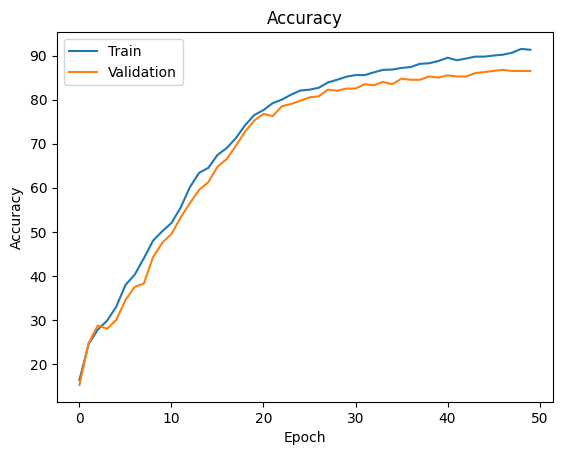

In [57]:
# TO DO: plot the training loss and validation accuracy (on two different subplots)
plt.figure()
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy')
plt.show()


<span style="color:red">**Q1**</span> Put the plot above (training loss and validation accuracy) in your report. What do you remark? Is it beneficial to do early stopping?

**Note**: Here, we actually conducted training for all epochs, and we simply recorded the best performing model. Proper early stopping would mean that we interrupt training when no improvement is observed after the best validation loss has been obtained (this number of epochs is called a *patience* parameter, since it corresponds to the "waiting time" after the best validation score is obtained).
This allows to reduce the computational time in addition to yielding the best model.


## Adjusting the model's capacity

The number of parameters in the network (i.e., the model's *capacity*) is expected to have a major impact on performance. Too few parameters might yield bad performance (underfitting), while too many might hamper the ability of the network to generalize (overfitting).


<center><a href="https://classic.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html">
    <img src="https://classic.d2l.ai/_images/capacity-vs-error.svg" width="400"></a></center>
    

Here, we study it by varying the number of hidden layers and checking how the validation accuracy behaves.

Below we consider a general classifier module, where the number of hidden layers is passed as an input parameter. To create and stack together several layers, we can use the [ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) object, along with a simple loop.

In [58]:
# On this example, we stack 5 {Linear + Relu} layers
list_layer = nn.ModuleList([nn.Sequential(nn.Linear(10, 10), nn.ReLU()) for l in range(5)])
print(list_layer)

ModuleList(
  (0-4): 5 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
)


In [59]:
# TO DO: write the MLP classifier'MLPClassif_var' (with '__init__' and 'forward' methods) with a variable number of hidden layers.
class MLPClassif_var(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden_layers):
        super(MLPClassif_var, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU()) for l in range(n_hidden_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        for layer in self.hidden_layers:
            y = layer(y)
        out = self.output_layer(y)
        return out

In [68]:
# TO DO:
# - Define the general parameters of the MLP classifier model and training (same as before)
# - For a number of hidden layers equal to 1, 3, and 5:
#      - Train the model
#      - Get the maximum validation accuracy
# - Plot the max accuracy as a function of the number of hidden layers

hidden_sizes = [1, 3, 5]
max_accuracies = []
train_accuracies_list = []

for hidden_size in hidden_sizes:
    model = MLPClassif_var(input_size, hidden_size, output_size, hidden_size)
    torch.manual_seed(0)
    model.apply(init_weights)
    model_opt, train_accuracies, val_accuracies = train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)
    max_accuracies.append(max(val_accuracies))

Epoch [1/50], Loss: 2.3029, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [2/50], Loss: 2.3040, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [3/50], Loss: 2.3009, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [4/50], Loss: 2.3028, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [5/50], Loss: 2.3001, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [6/50], Loss: 2.3010, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [7/50], Loss: 2.2970, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [8/50], Loss: 2.3033, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [9/50], Loss: 2.3067, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [10/50], Loss: 2.3058, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [11/50], Loss: 2.3043, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [12/50], Loss: 2.3009, Train Accuracy: 11.19%, Validation Accuracy: 11.25%
Epoch [13/50], Loss: 2.3091, Train Ac

<span style="color:red">**Q2**</span> Put the plot above (test accuracy as a function of number of hidden layers) in your report. What do you observe? What's the best model / number of hidden layers to use?

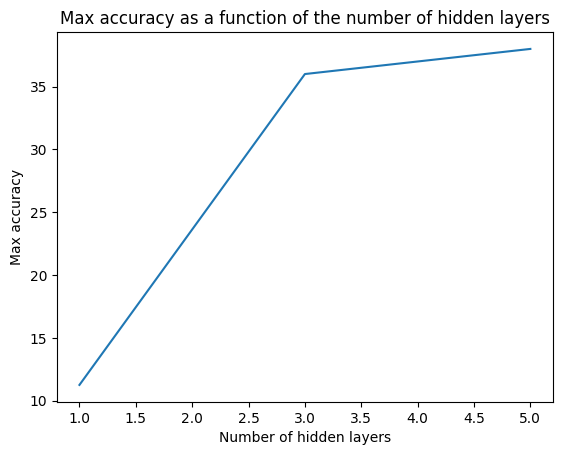

In [69]:
plt.figure()
plt.plot(hidden_sizes, max_accuracies)
plt.title('Max accuracy as a function of the number of hidden layers')
plt.xlabel('Number of hidden layers')
plt.ylabel('Max accuracy')
plt.show()